In [2]:
import torch
import numpy as np
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import CNNEmbedding, FCEmbedding
from sbi.inference import NPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis

from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
from scipy.stats import skew, kurtosis

from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

import matplotlib.pyplot as plt

In [3]:
# Generate random input signal
num_samples = 100
t_max = 10
num_timesteps = 64

np.random.seed(4)

# Generate random input signal
x_data = np.abs(np.cumsum(np.random.rand(num_samples, num_timesteps, 1) - 0.5, axis=1))
t_data = np.linspace(0, t_max, num_timesteps)

# Interpolate input signal to match time resolution
t = np.linspace(0, t_max, 500)
input_signal = np.interp(t, t_data, x_data[0, :, 0])

In [4]:
ts, dt = 30.0, 0.1
steps = int(ts / dt)

def amv(theta, tau_sequence=None, noise_std=0.0):

    Xu, Xuu, Yv, Yvv, Yr, Nv, Nr, Nrr = theta

    m   = 23.8
    Iz   = 1.76
    xg   = 0.046

    Xud  = -2
    Yvd  = -10
    Yrd  = 0
    Nvd  = 0
    Nrd  = -1

    m11 = m - Xud
    m22 = m - Yvd
    m23 = m * xg - Yrd
    m32 = m * xg - Nvd
    m33 = Iz - Nrd
    mt = m22 * m33 - m23 * m32

    a1 = dt * (m - Yvd) / (m - Xud)
    a2 = dt * (m * xg - Yrd) / (m - Xud)
    a3 = (-dt * (Iz - Nrd) * (m - Xud) / mt) + (dt * (m * xg - Yrd) * (m * xg - Yrd) / mt)
    a4 = dt * (m * xg - Yrd) * (Xud - Yvd) / mt
    a5 = (dt * (m * xg - Nvd) * (m - Xud) / mt) - (dt * (m - Yvd) * (m * xg - Yrd) / mt)
    a6 = -dt * (m - Yvd) * (Xud - Yvd) / mt

    b1  = dt * Xu / (m - Xud)
    b2  = dt * Xuu / (m - Xud)
    b3  = (dt * (Iz - Nrd) * Yv / mt) - (dt * (m * xg - Yrd) * Nv / mt)
    b4  = (dt * (Iz - Nrd) * Yr / mt) - (dt * (m * xg - Yrd) * Nr / mt)
    b5  = dt * (Iz - Nrd) * Yvv / mt
    b6  = -dt * (m * xg - Yrd) * Nrr / mt
    b7  = (dt * (m - Yvd) * Nv / mt) - (dt * (m * xg - Nvd) * Yv / mt)
    b8  = (dt * (m - Yvd) * Nr / mt) - (dt * (m * xg - Nvd) * Yr / mt)
    b9  = -dt * (m * xg - Nvd) * Yvv / mt
    b10 = dt * (m - Yvd) * Nrr / mt

    M = np.array([[m11, 0, 0], [0, m22, m23], [0, m32, m33]])
    B = dt * np.linalg.inv(M)
    
    zeta = np.array([
        a1, a2, b1, b2, a3, a4, b3, b4, b5, b6, a5, a6, b7, b8, b9, b10
    ])

    # Control input (default = fixed)
    if tau_sequence is None:
        tau_sequence = np.tile(np.array([[5, 10, 0]]), (steps, 1))

    # Initial state
    u, v, r = 0.0, 0.0, 0.0
    trajectory = []

    for i in range(steps):
        # Compute nonlinear basis vector f(ν_k)

        u_clamp = np.clip(u, -50, 50)
        v_clamp = np.clip(v, -50, 50)
        r_clamp = np.clip(r, -10, 10)

        f = np.array([
            [v_clamp * r_clamp, r_clamp**2, u_clamp, abs(u_clamp) * u_clamp, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, u_clamp * r_clamp, u_clamp * v_clamp, v_clamp, r_clamp, abs(v_clamp) * v_clamp, abs(r_clamp) * r_clamp]
        ])

        # Compute state update
        dnu = f @ zeta + (B @ tau_sequence[i].reshape(3, 1)).flatten()

        # Add noise if requested
        if noise_std > 0:
            dnu += np.random.normal(scale=noise_std, size=3)

        # Update state
        u, v, r = u + dnu[0], v + dnu[1], r + dnu[2]

        # Save state
        trajectory.append([u, v, r])

    return torch.tensor(trajectory, dtype=torch.float32)

In [5]:
def random_tau_sequence():
    t = np.linspace(0, ts, steps)
    tau = np.stack([
        5 * np.sin(0.2 * t) + 0.5 * np.random.randn(steps),
        3 * np.cos(0.1 * t) + 0.5 * np.random.randn(steps),
        0.2 * np.sin(0.4 * t)
    ], axis=1)
    return tau

In [6]:

def extract_summary_stats(trajectory: torch.Tensor, dt: float = 0.1):
    data = trajectory.numpy()  # shape (T, 3)
    summaries = []

    for i in range(3):  # for u, v, r
        x = data[:, i]

        # Time-domain features
        mean = np.mean(x)
        std = np.std(x)
        final = x[-1]
        max_val = np.max(x)
        min_val = np.min(x)
        peak_val = np.max(np.abs(x))
        peak_idx = np.argmax(np.abs(x))
        peak_time = peak_idx * dt
        rms = np.sqrt(np.mean(x**2))

        # Step-response features
        initial = x[0]
        overshoot = (max_val - final) / (final + 1e-8) if final != 0 else 0
        settling_time = next((i * dt for i in range(len(x)-1, -1, -1)
                              if abs(x[i] - final) > 0.02 * abs(final)), 0)

        # Frequency-domain (FFT)
        fft_vals = np.abs(rfft(x - np.mean(x)))
        freqs = rfftfreq(len(x), d=dt)
        power = fft_vals**2
        dominant_freq = freqs[np.argmax(power)]
        spectral_power = np.max(power)
        norm_power = power / (np.sum(power) + 1e-8)
        spec_entropy = entropy(norm_power)

        summaries.extend([
            mean, std, final, max_val, min_val,
            peak_val, peak_time, rms,
            dominant_freq, spectral_power, spec_entropy,
            overshoot, settling_time
        ])

    return torch.tensor(summaries, dtype=torch.float32)

In [7]:
def simulator(theta: torch.Tensor) -> torch.Tensor:
    # theta shape: (16,)
    trajectory = amv(theta.numpy(), tau_sequence=random_tau_sequence(), noise_std=0.05)
    summary = extract_summary_stats(trajectory)
    return summary

In [8]:
# True parameters
m_true   = 23.8
Iz_true   = 1.76
xg_true   = 0.046

Xud_true  = -2
Yvd_true  = -10
Yrd_true  = 0
Nvd_true  = 0
Nrd_true  = -1

Xu_true   = -0.7225
Xuu_true  = -1.3274
Yv_true   = -0.8612
Yvv_true  = -36.2823
Yr_true   = 0.1079
Nv_true   = 0.1052
Nr_true  = -0.5
Nrr_true = -1

true_params = torch.tensor([Xu_true, Xuu_true, Yv_true, Yvv_true, Yr_true, Nv_true, Nr_true, Nrr_true])

In [9]:
x_obs = amv(true_params.numpy(), tau_sequence=random_tau_sequence(), noise_std=0.02)
# x_obs = amv(true_params.numpy())

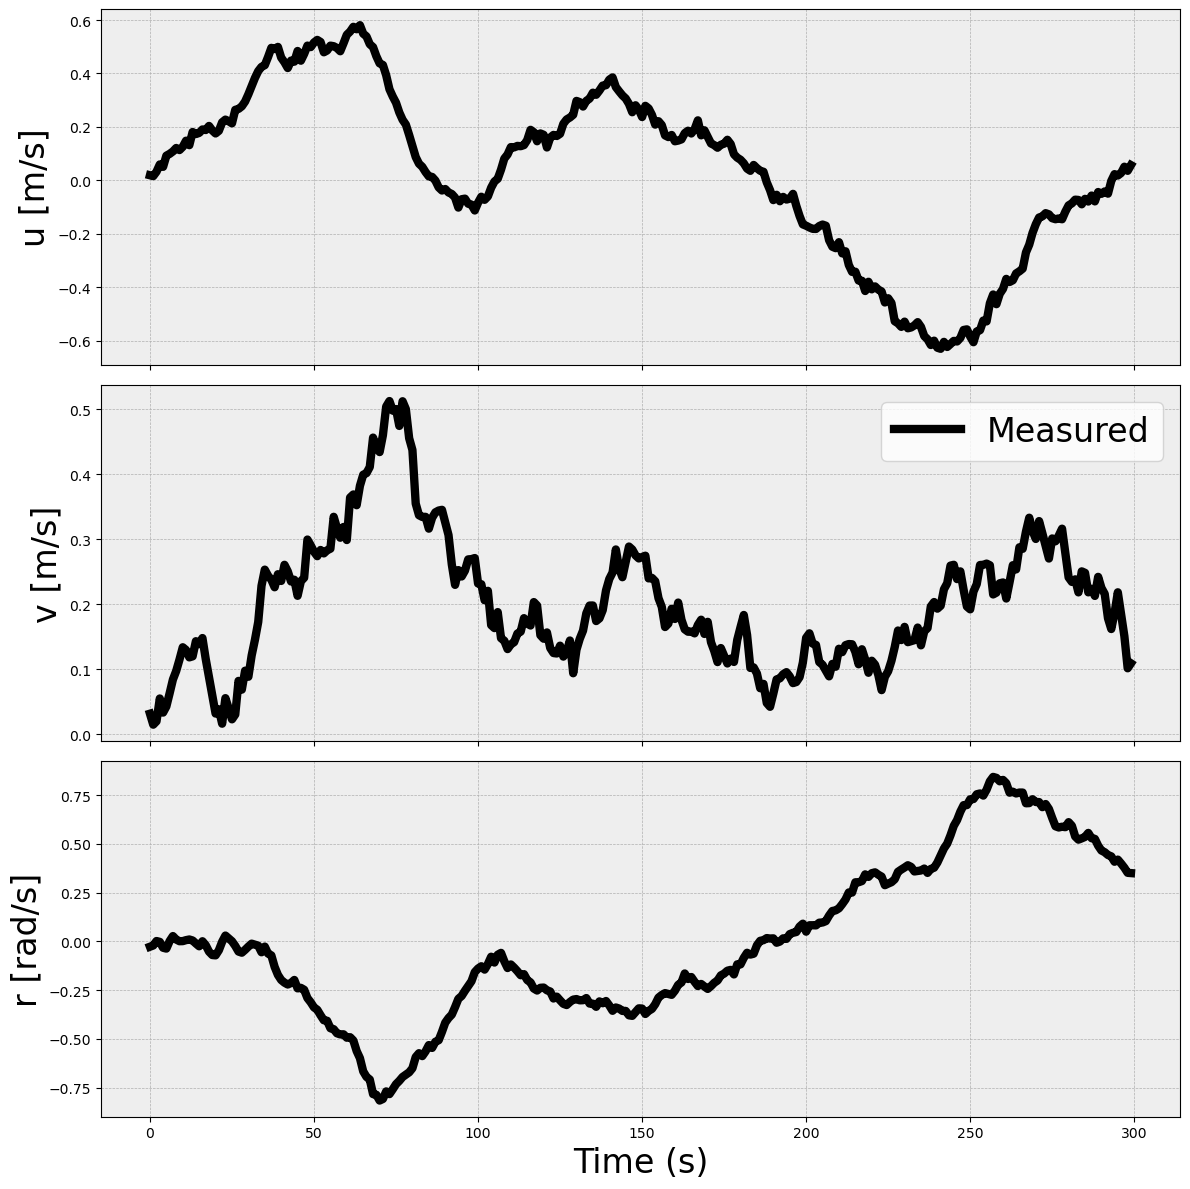

In [10]:
t = torch.arange(x_obs.shape[0])

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Define colors
bg_color = '#EEEEEE'
line_width = 6
font_size = 24

# Subplot 1: u [m/s]
axes[0].plot(t, x_obs[:, 0], '-k', linewidth=line_width, label='Measured')
axes[0].set_ylabel('u [m/s]', fontsize=font_size)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_facecolor(bg_color)

# Subplot 2: v [m/s]
axes[1].plot(t, x_obs[:, 1], '-k', linewidth=line_width, label='Measured')
axes[1].set_ylabel('v [m/s]', fontsize=font_size)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_facecolor(bg_color)
axes[1].legend(fontsize=font_size)

# Subplot 3: r [rad/s]
axes[2].plot(t, x_obs[:, 2], '-k', linewidth=line_width, label='Measured')
axes[2].set_ylabel('r [rad/s]', fontsize=font_size)
axes[2].set_xlabel('Time (s)', fontsize=font_size)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_facecolor(bg_color)

# Apply general figure settings
plt.tight_layout()
plt.show()

In [11]:
low = torch.tensor([
    -2.0,  # Xu
    -2.0,  # Xuu
    -2.0,  # Yv
    -50.0, # Yvv
    -1.0,  # Yr
    -1.0,  # Nv
    -1.5,  # Nr
    -2.0   # Nrr
])

high = torch.tensor([
    0.0,
    0.0,
    0.5,
    -20.0,
    1.0,
    1.0,
    0.0,
    0.0
])

In [12]:
prior = BoxUniform(
    low=low,
    high=high
)
prior, num_parameters, prior_returns_numpy = process_prior(prior)

In [13]:
simulator_wrapper = process_simulator(simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator_wrapper, prior)

In [22]:
inference = NPE(prior=prior)
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)
density_estimator = inference.append_simulations(theta, x).train()

  0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 56 epochs.

In [23]:
posterior = inference.build_posterior(density_estimator)

In [24]:
x_summary_obs = simulator(true_params)
samples = posterior.sample((5000,), x=x_summary_obs)

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

In [25]:
sample = prior.sample((1,))
observed_data_2 = simulator(sample[0])
# Infer parameters
samples_2 = posterior.sample((1000,), x=observed_data_2)
m_inferred_2 = samples_2.mean(dim=0)


print(f"Sampled 0: {sample[0][0]}, {m_inferred_2[0]}")
print(f"Sampled 1: {sample[0][1]}, {m_inferred_2[1]}")
print(f"Sampled 2: {sample[0][2]}, {m_inferred_2[2]}")
print(f"Sampled 3: {sample[0][3]}, {m_inferred_2[3]}")
print(f"Sampled 4: {sample[0][4]}, {m_inferred_2[4]}")
print(f"Sampled 5: {sample[0][5]}, {m_inferred_2[5]}")
print(f"Sampled 6: {sample[0][6]}, {m_inferred_2[6]}")
print(f"Sampled 7: {sample[0][7]}, {m_inferred_2[7]}")

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampled 0: -1.6527749300003052, -1.072796106338501
Sampled 1: -1.377042531967163, -1.0757408142089844
Sampled 2: -0.6748414039611816, -0.8379358053207397
Sampled 3: -39.04743957519531, -38.982826232910156
Sampled 4: -0.38304460048675537, 0.009931103326380253
Sampled 5: -0.8988122940063477, -0.39270728826522827
Sampled 6: -1.0271668434143066, -0.7664188146591187
Sampled 7: -0.419061541557312, -1.2974694967269897


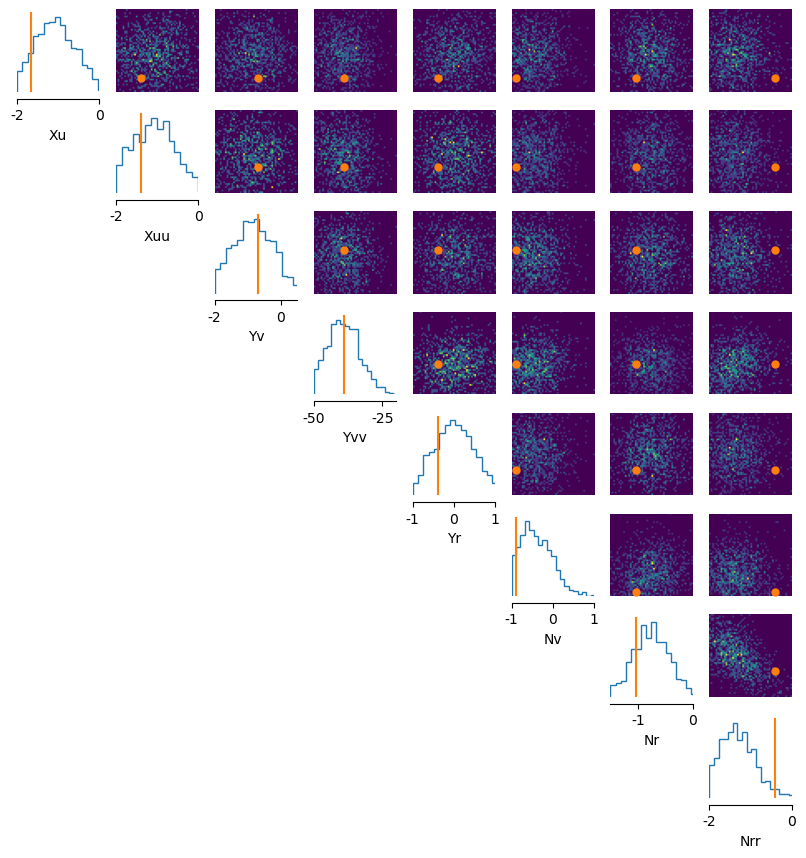

In [26]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]
labels=['Xu', 'Xuu', 'Yv', 'Yvv', 'Yr', 'Nv', 'Nr', 'Nrr']

fig, ax = analysis.pairplot(
    samples_2,
    points=sample,
    labels=labels,
    limits=limits,
)